In [1]:
"""
if x >= 4:          (4,5,6,7)
    if x >= 5:
        x+=1        (4,6,7,8)
    else:           
        x+=5        (9,6,7,8)       
        
else:               (0,1,2,3)
    if x >= 2:       
        x+=5        (0,1,7,8)

return x        (0,1,6,7,8,9)
"""

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import AerSimulator, Aer
from fpqs7 import fpqs_circ
import matplotlib.pyplot as plt
from QArithmetic import add, cadd, sub

In [2]:

# Registers and circuit.
b = QuantumRegister(4)
x = QuantumRegister(4)
anc = QuantumRegister(4)
cb = ClassicalRegister(4)
cx = ClassicalRegister(4)
canc = ClassicalRegister(4)
qc = QuantumCircuit(b, x, name="+4")# cc, cx, cb, cm, canc)
qc_new = QuantumCircuit(b, x, anc, cx)#, cb, cm, canc, cc)#cc, cx, cb, cm, canc)

# Init
qc_new.h(x[0]) # x = from 0000 to 0111 
qc_new.h(x[1])
qc_new.h(x[2])


qc_new.x(b[2]) # b = 0100

# x+4, in anc[0] goes the overflow
add(qc, b, x, 3)

qc_inv = qc.inverse()
qc_new.append(qc, range(0, len(qc.qubits)), range(0, len(qc.clbits)))

# cnot
qc_new.cx(x[3], anc[0])

# revert the +4
qc_new.append(qc_inv, range(0, len(qc.qubits)), range(0, len(qc.clbits)))

# controlled +3 based on a1
qc_new.x(b[0])
qc_new.x(b[1])
qc_new.x(b[2])

qc = QuantumCircuit(b, x, anc, name="c+3")
cadd(qc, anc[0], b, x, 3)

qc_new.append(qc, range(0, len(qc.qubits)), range(0, len(qc.clbits)))

qc_inv = qc.inverse()

qc_new.cx(x[3], anc[1])

qc_new.append(qc_inv, range(0, len(qc.qubits)), range(0, len(qc.clbits)))

# nested if +1
qc_new.x(b[1])

qc = QuantumCircuit(b, x, name="cc+1")
add(qc, b, x, 3)

qc_ctrl = qc.to_gate().control(2)

qc_new.append(qc_ctrl, list(range(len(qc.qubits), len(qc.qubits)+2)) + list(range(0, len(qc.qubits))), range(0, len(qc.clbits)))

# nested if +5
qc_new.x(b[2])

qc_new.x(anc[1])

qc = QuantumCircuit(b, x, name="cc+5")
add(qc, b, x, 3)

qc_ctrl = qc.to_gate().control(2)

qc_new.append(qc_ctrl, list(range(len(qc.qubits), len(qc.qubits)+2)) + list(range(0, len(qc.qubits))), range(0, len(qc.clbits)))

# controlled +6
qc_new.x(b[0])
qc_new.x(b[1])

qc_new.x(anc[0])

qc = QuantumCircuit(b, x, name="c+6")
add(qc, b, x, 3)

qc_ctrl = qc.to_gate().control(1)
qc_ctrl_inv = qc_ctrl.inverse()

qc_new.append(qc_ctrl, list(range(len(qc.qubits), len(qc.qubits)+1)) + list(range(0, len(qc.qubits))), range(0, len(qc.clbits)))

qc_new.cx(x[3], anc[2])

qc_new.append(qc_ctrl_inv, list(range(len(qc.qubits), len(qc.qubits)+1)) + list(range(0, len(qc.qubits))), range(0, len(qc.clbits)))

# nested if +5
qc_new.x(b[0])
qc_new.x(b[1])



qc = QuantumCircuit(b, x, name="cc+5")
add(qc, b, x, 3)

qc_ctrl = qc.to_gate().control(2)

qc_new.append(qc_ctrl, list(range(len(qc.qubits), len(qc.qubits)+3, 2)) + list(range(0, len(qc.qubits))), range(0, len(qc.clbits)))

qc_new.cx(x[3], anc[2])

#fpqs
def oracle(qc, num_qubits):
    # oracle to observe if an overflow happened
    qc.cx(7, qc.num_qubits-1)

A = qc_new

# Perform fixed-point quantum search
fpqs_qc = fpqs_circ(oracle, .5, 4, A, 4, 6)
qc_new.append(fpqs_qc, range(0, 12), range(0, 4))


from collections import defaultdict
counts = defaultdict(int)

# print(qc_new)
qc_new.measure(x, cx)

In [3]:
# perfect device simulation

# Simulate the circuit.
simulator = AerSimulator()
qct = transpile(qc_new, simulator)
# print(qc_new)

result = Aer.get_backend('statevector_simulator').run(qct, shots=30).result()
counts = result.get_counts()
print(counts)

{'0001': 1, '0000': 1, '0111': 1, '0110': 1, '1001': 9, '1000': 17}


In [5]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

# Run the sampler job locally using FakeManilaV2
# backend = FakeManilaV2()
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="a2b04c4de5dd6d8ef709c96ed105c700486f574ff3f8022079e7ee7aa2f9103515d8793719893bda6898029a21891e83487d6d095d2c4d753d5926c525a2d46b", overwrite=True, name="pz2", set_as_default=True)
# service = QiskitRuntimeService(name="pz2")
# backend = service.least_busy(operational=True, simulator=False)
from qiskit.providers.fake_provider import GenericBackendV2
backend = GenericBackendV2(12)

transpiled_circuit = transpile(qc_new, backend)
gate_count = transpiled_circuit.count_ops()
print(sum(gate_count.values()))

job = backend.run(transpiled_circuit)



# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# # Create a new circuit with two qubits (first argument) and two classical
# # bits (second argument)
# qc = QuantumCircuit(2)
# qc.h(0)
# qc.cx(0, 1)

# # Set up six different observables.
# observables_labels = ["ZZZZZZZZZZZZ"]

# from qiskit.quantum_info import SparsePauliOp
# observables = [SparsePauliOp(label) for label in observables_labels]


# pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
# isa_circuit = pm.run(qc_new)
# observables = [
#     observable.apply_layout(isa_circuit.layout) for observable in observables
# ]

# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
# isa_bell = pm.run(qc_new)

# sampler = Sampler(backend)

# job = sampler.run([(isa_bell,)])
# result = job.result()

# sub: 63
# mult: 113
# div: 286
# flow sens overflow: 176769 

176769


In [12]:
result = job.result()

In [15]:
counts = result.get_counts()

{'1011': 41, '0001': 48, '1111': 31, '0000': 148, '0010': 96, '0100': 96, '0111': 23, '0011': 38, '1101': 28, '1110': 56, '1001': 38, '0101': 47, '1100': 84, '0110': 71, '1000': 104, '1010': 75}


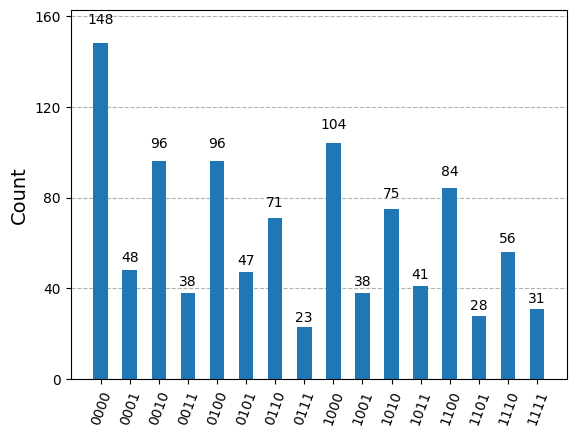

In [17]:
from qiskit.visualization import plot_histogram
print(counts)
plot_histogram(counts)

In [ ]:
print(dir(result))
# pub_result = result[0]
# print(f" >> Counts for the meas output register: {pub_result.data.meas.get_counts()}")

In [ ]:
# Prepare the input circuit.
from qiskit import QuantumCircuit

bell = QuantumCircuit(2)
bell.h(0)
bell.cx(0, 1)
bell.measure_all()

# Execute the circuit
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.providers.fake_provider import GenericBackendV2

# Run the sampler job locally using FakeManilaV2
backend = GenericBackendV2(12)

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_bell = pm.run(bell)

sampler = Sampler(backend)

job = sampler.run([(isa_bell,)])
result = job.result()

pub_result = result[0]
# Get counts from the classical register "meas".
print(f" >> Counts for the meas output register: {pub_result.data.meas.get_counts()}")

In [ ]:
# noisy hardware simulation
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator, Sampler as AerSampler

coupling_map = [(i, i + 1) for i in range(qc_new.num_qubits-1)]
device = GenericBackendV2(num_qubits=qc_new.num_qubits, coupling_map=coupling_map, seed=54)

seed = 170
algorithm_globals.random_seed = seed

noise_model = NoiseModel.from_backend(device)

sampler = AerSampler(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": 12},
    transpile_options={"seed_transpiler": seed},
)

job = sampler.run(qc_new, shots=12)

dists = job.result().quasi_dists

counts = {key: int(value * 12) for key, value in dists[0].items()}
print(counts)